<a href="https://colab.research.google.com/github/SAMAWELJABALLI/TweetsSentimentAnalysis/blob/main/Logistic_regression_Tunisian__Dialect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **THE LOGISTIC REGRESSION MODEL ON TUNISIAN DIALECT**

In [10]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix,classification_report,roc_curve, auc, accuracy_score
from sklearn import metrics
from nltk.stem.porter import PorterStemmer
from sklearn.linear_model import LogisticRegression
from bs4 import BeautifulSoup
import re
import string
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.manifold import TSNE
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
import seaborn as sns
from tqdm import tqdm
import os


In [11]:
# Load data and set labels from corpus 1 
df = pd.read_csv('/content/data_clean.csv', lineterminator='\n')
print(f'Shape of data is {df.shape}')
# Display 20 random samples
df.drop(columns=["text", "message_len"],inplace=True)
df.sample(20)

Shape of data is (199097, 6)


,Unnamed: 0,ID,label,text_clean
21624,21624,21624,1,yelzem le elkol etsker w couver feu
69786,71405,21514,1,flow
196928,203862,67745,1,waiting
6979,6979,6979,1,barcha
160269,165847,29730,1,kifeh w yheb sahafi
80659,83186,33295,0,مكان التواجد محدود جدا
25450,25450,25450,1,ويني المواني المسكرة
186196,192710,56593,0,mala karakous
83201,85929,36038,1,المنتجات المعروضة جيدة ولكن يجب توسيع العرض كم...
110400,114954,5655,1,arbia mallaoui


# Loading saved vectors 


In [3]:
# loading bow vectors
X_train_bow = pickle.load(open("/content/drive/MyDrive/saved_feats/X_train_bow","rb"))
X_test_bow = pickle.load(open("/content/drive/MyDrive/saved_feats/X_test_bow","rb"))
bow_features = pickle.load(open("/content/drive/MyDrive/saved_feats/bow_features","rb")).tolist()
print('shape of X_train_bow is {}'.format(X_train_bow.shape))
print('shape of X_test_bow is {}'.format(X_test_bow.shape))


#loading tfidf vectors
X_train_tfidf = pickle.load(open("/content/drive/MyDrive/saved_feats/X_train_tfidf","rb"))
X_test_tfidf = pickle.load(open("/content/drive/MyDrive/saved_feats/X_test_tfidf","rb"))
tfidf_features = pickle.load(open("/content/drive/MyDrive/saved_feats/tfidf_features","rb")).tolist()
print('shape of X_train_tfidf is {}'.format(X_train_tfidf.shape))
print('shape of X_test_tfidf is {}'.format(X_test_tfidf.shape))


w2v_words = pickle.load(open("/content/drive/MyDrive/saved_feats/w2v_words","rb")).tolist()
#avgw2v
X_train_avgw2v = pickle.load(open("/content/drive/MyDrive/saved_feats/X_train_avgw2v","rb"))
X_test_avgw2v = pickle.load(open("/content/drive/MyDrive/saved_feats/X_test_avgw2v","rb"))
print('shape of X_train_avgw2v is {}'.format(X_train_avgw2v.shape))
print('shape of X_test_avgw2v is {}'.format(X_test_avgw2v.shape))

'''#tfidf-w2v
X_train_tfw2v = pickle.load(open("/content/drive/MyDrive/saved_feats/X_train_tfw2v","rb"))
X_test_tfw2v = pickle.load(open("/content/drive/MyDrive/saved_feats/X_test_tfw2v","rb"))
print('shape of X_train_tfw2v is {}'.format(X_train_tfw2v.shape))
print('shape of X_test_tfw2v is {}'.format(X_test_tfw2v.shape))

'''
y_train = np.load('/content/drive/MyDrive/saved_feats/y_train.npy',allow_pickle=True)
y_test = np.load('/content/drive/MyDrive/saved_feats/y_test.npy',allow_pickle=True)
print(f'shape of y_train is {y_train.shape}')
print(f'shape of y_test is {y_test.shape}')

shape of X_train_bow is (139367, 144497)
shape of X_test_bow is (59730, 144497)
shape of X_train_tfidf is (139367, 144497)
shape of X_test_tfidf is (59730, 144497)
shape of X_train_avgw2v is (139367, 50)
shape of X_test_avgw2v is (59730, 50)
shape of y_train is (139367,)
shape of y_test is (59730,)


In [32]:
#tfidf-w2v
X_train_tfw2v = pickle.load(open("/content/drive/MyDrive/saved_feats/X_train_tfw2v","rb"),)
X_test_tfw2v = pickle.load(open("/content/drive/MyDrive/saved_feats/X_test_tfw2v","rb"))
print('shape of X_train_tfw2v is {}'.format(X_train_tfw2v.shape))
print('shape of X_test_tfw2v is {}'.format(X_test_tfw2v.shape))

UnpicklingError: ignored

# helper function to plot confusion matrix

In [5]:
# helper function to plot confusion matrix
def plot_confusion_matrixes(model,x_train,y_train,x_test,y_test):
    cm_train = confusion_matrix(y_train,model.predict(x_train))
    cm_test =  confusion_matrix(y_test,model.predict(x_test))
    class_label = ["negative", "positive"]
    df_train = pd.DataFrame(cm_train, index = class_label, columns = class_label)
    df_test = pd.DataFrame(cm_test, index = class_label, columns = class_label)
    f, axes = plt.subplots(1, 2,figsize=(12,4))

    for i in range(2):
      df = df_train if i==0 else df_test
      sns.heatmap(df, annot = True, fmt = "d",ax=axes[i])
      axes[i].set_title(f"Confusion Matrix - {'Train' if i==0 else 'Test'}")
      axes[i].set_xlabel("Predicted Label")
      axes[i].set_ylabel("True Label")
    plt.show()

# **Logistic regression**

##Logistic Regression On Bow

Model with best parameters :
 {'C': 1000, 'penalty': 'l2'}


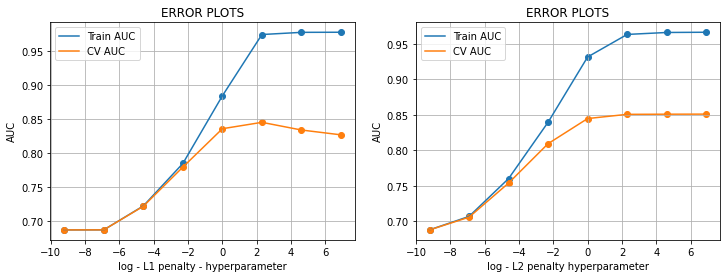

In [6]:
penalty = ['l1','l2']
C = [0.0001,0.001,0.01,0.1,1,10,100,1000]

grid={"penalty":penalty,"C":C}
logreg=LogisticRegression(solver='liblinear')
model=GridSearchCV(logreg,grid,cv=5,return_train_score=True)
model.fit(X_train_bow,y_train)

print("Model with best parameters :\n",model.best_params_)

f, axes = plt.subplots(1, 2,figsize=(12,4))

for i in range(2):
  title = 'log - L1 penalty - hyperparameter' if i ==0 else 'log - L2 penalty hyperparameter'
  train_auc = model.cv_results_['mean_train_score'][0+i:16+i:2]
  cv_auc = model.cv_results_['mean_test_score'][0+i:16+i:2]
  axes[i].plot(np.log(C), train_auc, label='Train AUC')
  axes[i].plot(np.log(C), cv_auc, label='CV AUC')
  axes[i].scatter(np.log(C), train_auc)
  axes[i].grid(True)
  axes[i].legend()
  axes[i].scatter(np.log(C), cv_auc)
  axes[i].set_xlabel(title)
  axes[i].set_ylabel("AUC")
  axes[i].set_title("ERROR PLOTS")

plt.show()

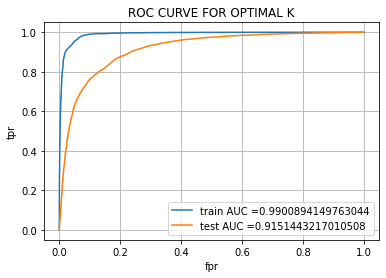

Area under train roc 0.9900894149763044
Area under test roc 0.9151443217010508


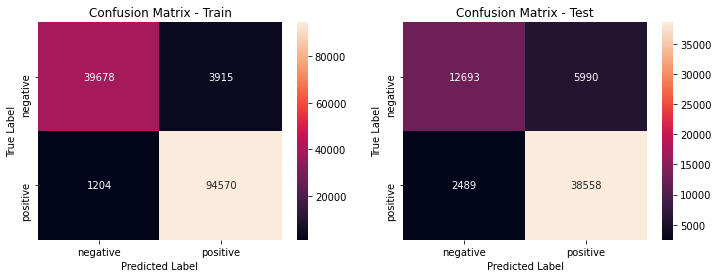


-----classification report on train data on BagOfwords Features-----

              precision    recall  f1-score   support

           0       0.97      0.91      0.94     43593
           1       0.96      0.99      0.97     95774

    accuracy                           0.96    139367
   macro avg       0.97      0.95      0.96    139367
weighted avg       0.96      0.96      0.96    139367


-----classification report on validation data on BagOfwords Features-----

              precision    recall  f1-score   support

           0       0.84      0.68      0.75     18683
           1       0.87      0.94      0.90     41047

    accuracy                           0.86     59730
   macro avg       0.85      0.81      0.83     59730
weighted avg       0.86      0.86      0.85     59730



In [12]:
clf_l1_opt = LogisticRegression(**model.best_params_,solver='liblinear')
clf_l1_opt = clf_l1_opt.fit(X_train_bow,y_train)
train_fpr, train_tpr, thresholds = roc_curve(y_train, clf_l1_opt.predict_proba(X_train_bow)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, clf_l1_opt.predict_proba(X_test_bow)[:,1])

plt.grid(True)
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC CURVE FOR OPTIMAL K")
plt.show()

#Area under ROC curve
print('Area under train roc {}'.format(auc(train_fpr, train_tpr)))
print('Area under test roc {}'.format(auc(test_fpr, test_tpr)))
plot_confusion_matrixes(clf_l1_opt,X_train_bow,y_train,X_test_bow,y_test)

#classification report on train data
print('\n-----classification report on train data on BagOfwords Features-----\n')
print(classification_report(y_train, clf_l1_opt.predict(X_train_bow)))

#classification report on validation data
print('\n-----classification report on validation data on BagOfwords Features-----\n')
print(classification_report(y_test, clf_l1_opt.predict(X_test_bow)))

# **Feature importance**

In [13]:
data_l2 = clf_l1_opt.coef_.reshape(-1,1)

datafr_l2 = pd.DataFrame(data_l2,columns=['coef'],index=bow_features)
#Top 10 negative features
negative = datafr_l2.sort_values(by='coef').head(10)
#Top 10 positive features
positive = datafr_l2.sort_values(by='coef',ascending=False).head(10)
print('Top 10 negative features are: \n {}'.format(negative))
print('--'*50)
print('Top 10 positive features are: \n {}'.format(positive))

Top 10 negative features are: 
                 coef
arnaqueurs -6.479795
larnaque   -6.236687
tfouh      -6.031256
تافه       -5.821713
ماسط       -5.577524
طحان       -5.507992
maset      -5.443333
يهلكم      -5.293545
كلب        -5.177741
masit      -5.080449
----------------------------------------------------------------------------------------------------
Top 10 positive features are: 
                  coef
kadhebin     4.778056
boy          4.748806
دق           4.677363
احكي         4.639743
bravooooo    4.587876
مزالت        4.492385
bravoo       4.449232
ness_nessma  4.434462
adore        4.432437
superbe      4.383911


# Logistic regression on TFIDF features

Model with best parameters :
 {'C': 10, 'penalty': 'l2'}


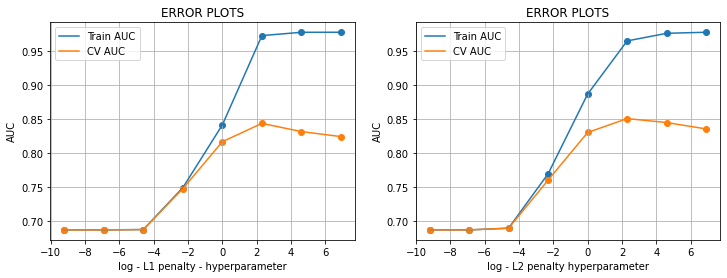

CPU times: user 3min 50s, sys: 2min 51s, total: 6min 42s
Wall time: 3min 51s


In [14]:
%%time
penalty = ['l1','l2']
C = [0.0001,0.001,0.01,0.1,1,10,100,1000]

grid={"penalty":penalty,"C":C}
logreg=LogisticRegression(solver='liblinear')
model=GridSearchCV(logreg,grid,cv=5,return_train_score=True)
model.fit(X_train_tfidf,y_train)

print("Model with best parameters :\n",model.best_params_)

f, axes = plt.subplots(1, 2,figsize=(12,4))

for i in range(2):
  title = 'log - L1 penalty - hyperparameter' if i ==0 else 'log - L2 penalty hyperparameter'
  train_auc = model.cv_results_['mean_train_score'][0+i:16+i:2]
  cv_auc = model.cv_results_['mean_test_score'][0+i:16+i:2]
  axes[i].plot(np.log(C), train_auc, label='Train AUC')
  axes[i].plot(np.log(C), cv_auc, label='CV AUC')
  axes[i].scatter(np.log(C), train_auc)
  axes[i].grid(True)
  axes[i].legend()
  axes[i].scatter(np.log(C), cv_auc)
  axes[i].set_xlabel(title)
  axes[i].set_ylabel("AUC")
  axes[i].set_title("ERROR PLOTS")

plt.show()

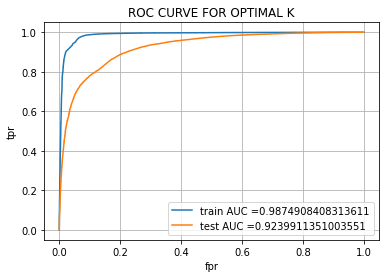

Area under train roc 0.9874908408313611
Area under test roc 0.9239911351003551


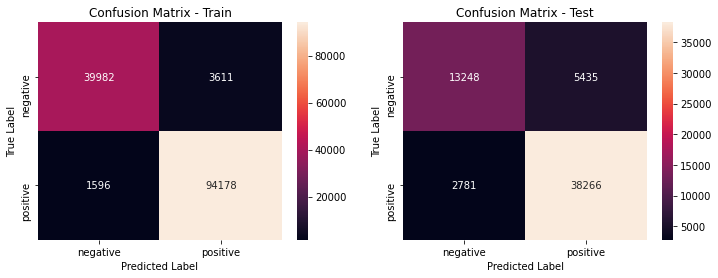


-----classification report on train data on BagOfwords Features-----

              precision    recall  f1-score   support

           0       0.96      0.92      0.94     43593
           1       0.96      0.98      0.97     95774

    accuracy                           0.96    139367
   macro avg       0.96      0.95      0.96    139367
weighted avg       0.96      0.96      0.96    139367


-----classification report on validation data on BagOfwords Features-----

              precision    recall  f1-score   support

           0       0.83      0.71      0.76     18683
           1       0.88      0.93      0.90     41047

    accuracy                           0.86     59730
   macro avg       0.85      0.82      0.83     59730
weighted avg       0.86      0.86      0.86     59730



In [15]:
clf_l1_opt = LogisticRegression(**model.best_params_,solver='liblinear')
clf_l1_opt = clf_l1_opt.fit(X_train_tfidf,y_train)
train_fpr, train_tpr, thresholds = roc_curve(y_train, clf_l1_opt.predict_proba(X_train_tfidf)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, clf_l1_opt.predict_proba(X_test_tfidf)[:,1])

plt.grid(True)
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC CURVE FOR OPTIMAL K")
plt.show()

#Area under ROC curve
print('Area under train roc {}'.format(auc(train_fpr, train_tpr)))
print('Area under test roc {}'.format(auc(test_fpr, test_tpr)))
plot_confusion_matrixes(clf_l1_opt,X_train_tfidf,y_train,X_test_tfidf,y_test)

#classification report on train data
print('\n-----classification report on train data on TFIDF Features-----\n')
print(classification_report(y_train, clf_l1_opt.predict(X_train_tfidf)))

#classification report on validation data
print('\n-----classification report on validation data on TFIDF Features-----\n')
print(classification_report(y_test, clf_l1_opt.predict(X_test_tfidf)))

# **Feature importance**

In [16]:
data_l2 = clf_l1_opt.coef_.reshape(-1,1)

datafr_l2 = pd.DataFrame(data_l2,columns=['coef'],index=tfidf_features)
#Top 10 negative features
negative = datafr_l2.sort_values(by='coef').head(10)
#Top 10 positive features
positive = datafr_l2.sort_values(by='coef',ascending=False).head(10)
print('Top 10 negative features are: \n {}'.format(negative))
print('--'*50)
print('Top 10 positive features are: \n {}'.format(positive))

Top 10 negative features are: 
                 coef
larnaque   -9.987925
ماسط       -9.948293
tfouh      -9.897442
maset      -9.050503
arnaque    -8.889028
تافه       -8.806777
nul        -8.234284
سئ         -8.122092
nulle      -8.099494
arnaqueurs -8.071302
----------------------------------------------------------------------------------------------------
Top 10 positive features are: 
               coef
bravo    13.038030
ممتاز     8.504084
bonne     8.485720
برافو     8.088243
mabrouk   7.722692
sakrou    7.418533
ربي       7.316289
شكرا      7.158639
superbe   6.714173
adore     6.695452


# Logistic regression on Average Word2Vec


Model with best parameters :
 {'C': 100, 'penalty': 'l1'}


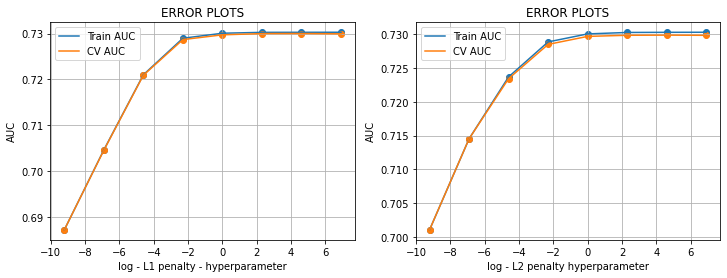

In [17]:
%%time
penalty = ['l1','l2']
C = [0.0001,0.001,0.01,0.1,1,10,100,1000]

grid={"penalty":penalty,"C":C}
logreg=LogisticRegression(solver='liblinear')
model=GridSearchCV(logreg,grid,cv=5,return_train_score=True)
model.fit(X_train_avgw2v,y_train)

print("Model with best parameters :\n",model.best_params_)

f, axes = plt.subplots(1, 2,figsize=(12,4))

for i in range(2):
  title = 'log - L1 penalty - hyperparameter' if i ==0 else 'log - L2 penalty hyperparameter'
  train_auc = model.cv_results_['mean_train_score'][0+i:16+i:2]
  cv_auc = model.cv_results_['mean_test_score'][0+i:16+i:2]
  axes[i].plot(np.log(C), train_auc, label='Train AUC')
  axes[i].plot(np.log(C), cv_auc, label='CV AUC')
  axes[i].scatter(np.log(C), train_auc)
  axes[i].grid(True)
  axes[i].legend()
  axes[i].scatter(np.log(C), cv_auc)
  axes[i].set_xlabel(title)
  axes[i].set_ylabel("AUC")
  axes[i].set_title("ERROR PLOTS")

plt.show()

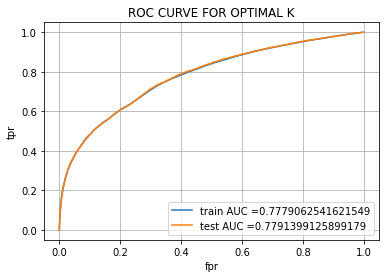

Area under train roc 0.7779062541621549
Area under test roc 0.7791399125899179


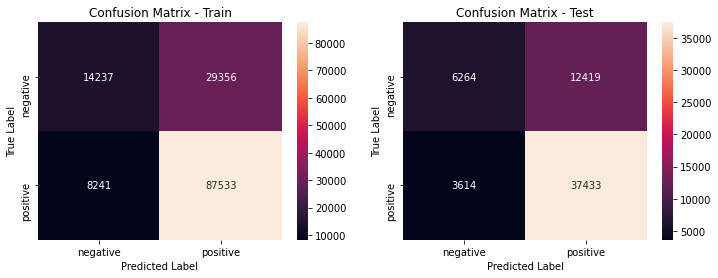


-----classification report on train data on Averge word2vec -----

              precision    recall  f1-score   support

           0       0.63      0.33      0.43     43593
           1       0.75      0.91      0.82     95774

    accuracy                           0.73    139367
   macro avg       0.69      0.62      0.63    139367
weighted avg       0.71      0.73      0.70    139367


-----classification report on validation data on Averge word2vec -----

              precision    recall  f1-score   support

           0       0.63      0.34      0.44     18683
           1       0.75      0.91      0.82     41047

    accuracy                           0.73     59730
   macro avg       0.69      0.62      0.63     59730
weighted avg       0.71      0.73      0.70     59730



In [18]:
clf_l1_opt = LogisticRegression(**model.best_params_,solver='liblinear')
clf_l1_opt = clf_l1_opt.fit(X_train_avgw2v,y_train)
train_fpr, train_tpr, thresholds = roc_curve(y_train, clf_l1_opt.predict_proba(X_train_avgw2v)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, clf_l1_opt.predict_proba(X_test_avgw2v)[:,1])

plt.grid(True)
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC CURVE FOR OPTIMAL K")
plt.show()

#Area under ROC curve
print('Area under train roc {}'.format(auc(train_fpr, train_tpr)))
print('Area under test roc {}'.format(auc(test_fpr, test_tpr)))
plot_confusion_matrixes(clf_l1_opt,X_train_avgw2v,y_train,X_test_avgw2v,y_test)

#classification report on train data
print('\n-----classification report on train data on Averge word2vec -----\n')
print(classification_report(y_train, clf_l1_opt.predict(X_train_avgw2v)))

#classification report on validation data
print('\n-----classification report on validation data on Averge word2vec -----\n')
print(classification_report(y_test, clf_l1_opt.predict(X_test_avgw2v)))

# **Observations and Conclusions**


In [36]:
from prettytable import PrettyTable
    
z = PrettyTable()

z.field_names = ["Vector","Algorithm","regulariation", "Hyperparameter-C", "Train AUC", "Test AUC","Train accuracy", "Test accuracy"]

z.add_row(["bow","logistic regression","l2",1000,0.9900894149763044, 0.9151443217010508, 0.96,0.86])
z.add_row(["tfidf","logistic regression","l2",10,0.9874908408313611,0.9239911351003551,0.96,0.86])    
z.add_row(["avg-word2vec","logistic regression","l1",100,0.7779062541621549,0.7779062541621549,0.73,0.73])
#z.add_row(["tfidf-word2vec","logistic regression","l1",10,0.8857145235571816,0.8847929213341348])

print(z)

+--------------+---------------------+---------------+------------------+--------------------+--------------------+----------------+---------------+
|    Vector    |      Algorithm      | regulariation | Hyperparameter-C |     Train AUC      |      Test AUC      | Train accuracy | Test accuracy |
+--------------+---------------------+---------------+------------------+--------------------+--------------------+----------------+---------------+
|     bow      | logistic regression |       l2      |       1000       | 0.9900894149763044 | 0.9151443217010508 |      0.96      |      0.86     |
|    tfidf     | logistic regression |       l2      |        10        | 0.9874908408313611 | 0.9239911351003551 |      0.96      |      0.86     |
| avg-word2vec | logistic regression |       l1      |       100        | 0.7779062541621549 | 0.7779062541621549 |      0.73      |      0.73     |
+--------------+---------------------+---------------+------------------+--------------------+------------